# Greening trends XGBoost model - local run with loop

### Peter R.
#### 2025-04-04

Here we use BFAST trends derived from 5-year periods of forest EVI (enhanced vegetation index) time series (ts) observations. These trends were produced using a BFAST01 *h* parameter equal to 0.05 (or ~ 5% of the ts) and BFAST Classify (p < 0.05). Trends were modelled using Extreme Gradient Boosting (XGBoost) regression. The response variable is forest EVI trend slope and predictors are forest and climate-related variables. The code below is for positive breaks only.  

The data used here were produced with R and DuckDb. Climate variables were created using ClimateNA. A bigger set of climate variables were shortlisted using variation inflation factor (VIF). The code for putting the data frame together is not shown here.

We decided to test XGB models (boosted regression trees, BRT) with subsets of data. The following XGB models and dataframe subsets are run:

- Dataframe3 (df0): All records

- Dataframe6 (df3): Disturbed records only

- Dataframe9 (df6): Undisturbed records only

This notebook has three main parts. The first one runs XGBoost with different subsets of the data. The second part does the same but removes records matched with disturbance data. The last part, runs the best model and creates figures. 

In this version I run models for periods 1 to 4.

- Period 1: 2003-2007
- Period 2: 2008-2012
- Period 3: 2013-2017
- Period 4: 2018-2022

Some points to have in mind:

- Some of the XGBoost parameter values used below were obtained by using RandomizedSearchCV available in Scikit-learn. This step  is not shown here.

- Given that Canlad data (Guideon *et al.* 2017) had the most matches (spatiotemporal overlap) with trend data we used this data source to filter out matched trends. This was done so that variation by forest and climate-related predictors can be better tunned in.

- I should try to further optimize the XGB parameters. I did and the best models do not chnage only the R2-adj gets slighlty better. Perhaps I should use the new parameters for Ch. 3.

- I would like to run a classify XGB (outcomes: G, B, abd N) to see what factors are associted with 'no change detected' (N) pixels.


### Setup

In [153]:
# Peter R.
# XGBoost script

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_stpa\models\xgboost\exploratory')


print("XGB version:", xgb.__version__)
print("positive trends")


# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p1_vars_greening_v5.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
df11 = pd.get_dummies(df11, columns=['gfc'], dtype=float)
df11 = pd.get_dummies(df11, columns=['canlad'], dtype=float)
df11 = pd.get_dummies(df11, columns=['insc'], dtype=float)
df11 = pd.get_dummies(df11, columns=['abio'], dtype=float)



XGB version: 1.7.6
positive trends


In [154]:
# Period 2 models
# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p2_vars_greening_v5.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df21 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
df21 = pd.get_dummies(df21, columns=['gfc'], dtype=float)
df21 = pd.get_dummies(df21, columns=['canlad'], dtype=float)
df21 = pd.get_dummies(df21, columns=['insc'], dtype=float)
df21 = pd.get_dummies(df21, columns=['abio'], dtype=float)

In [155]:
# Period 3 models
# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p3_vars_greening_v5.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df31 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
df31 = pd.get_dummies(df31, columns=['gfc'], dtype=float)
df31 = pd.get_dummies(df31, columns=['canlad'], dtype=float)
df31 = pd.get_dummies(df31, columns=['insc'], dtype=float)
df31 = pd.get_dummies(df31, columns=['abio'], dtype=float)

In [156]:
# Period 4 models
# Windows
df1 = pd.read_csv(r'.\data\df2_trends_p4_vars_greening_v5.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df41 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)
df41 = pd.get_dummies(df41, columns=['gfc'], dtype=float)
df41 = pd.get_dummies(df41, columns=['canlad'], dtype=float)
df41 = pd.get_dummies(df41, columns=['insc'], dtype=float)
df41 = pd.get_dummies(df41, columns=['abio'], dtype=float)

In [157]:
# Notes
# - Here I am reorganizing the columns so that all dfs have the outcome as the first column
#Df0: all rows (including nulls)
df0 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0)]

# Df3:
#df3 = df11.dropna()
#df3 = df11.loc[(df11['gfc_0'] = 0) & (df11['canlad_0']  = 0) & (df11['insc_0']  = 0) & (df11['abio_0']  = 0)] # undisturbed pix
#df3.describe()

#Df21: period2 full dataset
df20 = df21.loc[(df21['for_age_2008'] >= 0) & (df21['elev'] > 0)]
#Df31: period3 full dataset
df30 = df31.loc[(df31['for_age_2013'] >= 0) & (df31['elev'] > 0)]
#Df41: period4 full dataset
df40 = df41.loc[(df41['for_age_2018'] >= 0) & (df41['elev'] > 0)]


#dfall = [df0, df3, df6, df9, df23]
#dfall = [df0, df3] # df0 & df3 are the same df so far
#dfall = [df0]
dfall = [df0, df20, df30, df40]

#Df0: all rows
#dfall = [df11]


In [158]:
print(dfall[3].describe())  # 11018,77834, 35242, 116166

                 pix      year   for_age_2018   for_con_2018           elev  \
count  116166.000000  116166.0  116166.000000  116162.000000  116166.000000   
mean   244807.814498    2018.0      83.761308      29.566055     415.594674   
std    136343.735858       0.0      11.558568      28.506537      70.830379   
min       478.000000    2018.0       9.730000       0.345000     118.513000   
25%    133417.250000    2018.0      79.115000       6.837250     380.666250   
50%    245386.500000    2018.0      84.395000      17.355500     430.981000   
75%    361357.750000    2018.0      87.986000      46.437000     466.651000   
max    493406.000000    2018.0     149.513000      98.909000     564.493000   

       p4_trend  p4_trend_slope   trend_20yrs     gfc_tsince       gfc_wsum  \
count  116166.0   116166.000000  50381.000000  116166.000000  116166.000000   
mean        1.0        5.196230      2.058871       1.556032       0.216778   
std         0.0        1.264271      1.872999      

In [159]:
(dfall[0]).head()
#range(len(dfall))

,pix,year,for_age_2003,for_con_2003,elev,p1_trend,p1_trend_slope,trend_20yrs,gfc_tsince,gfc_wsum,...,for_pro_0,for_pro_1,gfc_0,gfc_1,canlad_0,canlad_1,insc_0,insc_1,abio_0,abio_1
0,40703,2003,69.483,32.010,448.891,1,3.560,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,41067,2003,80.113,20.613,238.661,1,3.855,NaN,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,41075,2003,77.236,25.896,242.215,1,3.200,NaN,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,41642,2003,66.421,27.345,375.301,1,3.456,NaN,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7,41645,2003,78.383,41.741,358.044,1,5.726,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [160]:
(dfall[1]).head()

,pix,year,for_age_2008,for_con_2008,elev,p2_trend,p2_trend_slope,trend_20yrs,gfc_tsince,gfc_wsum,...,for_pro_0,for_pro_1,gfc_0,gfc_1,canlad_0,canlad_1,insc_0,insc_1,abio_0,abio_1
0,350536,2008,88.267,54.805,313.345,1,4.459,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,350537,2008,87.715,38.610,316.271,1,5.515,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,350538,2008,82.607,29.892,316.236,1,3.645,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,350540,2008,87.342,25.377,339.339,1,5.660,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,350547,2008,91.356,31.959,416.111,1,4.960,1.0,0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [161]:
(dfall[2]).head()

,pix,year,for_age_2013,for_con_2013,elev,p3_trend,p3_trend_slope,trend_20yrs,gfc_tsince,gfc_wsum,...,for_pro_0,for_pro_1,gfc_0,gfc_1,canlad_0,canlad_1,insc_0,insc_1,abio_0,abio_1
0,35470,2013,69.708,54.296,356.642,1,4.277,NaN,0,0.000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,35638,2013,80.459,43.466,399.030,1,3.571,1.0,0,0.000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,35726,2013,81.535,46.041,378.061,1,3.659,5.0,14,2.533,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,36942,2013,94.637,35.561,257.816,1,3.804,NaN,0,0.000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5,38525,2013,74.477,65.503,334.489,1,3.292,1.0,0,0.000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [162]:
(dfall[3]).head()

,pix,year,for_age_2018,for_con_2018,elev,p4_trend,p4_trend_slope,trend_20yrs,gfc_tsince,gfc_wsum,...,dd5_wt_rel30p_reg,for_pro_0,for_pro_1,gfc_0,gfc_1,canlad_0,insc_0,insc_1,abio_0,abio_1
0,240473,2018,65.836,38.659,321.691,1,3.583,NaN,0,0.0,...,46.667,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,240492,2018,77.344,60.997,180.713,1,4.155,NaN,0,0.0,...,73.333,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,240494,2018,74.939,80.755,179.152,1,4.142,NaN,0,0.0,...,73.333,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,240518,2018,104.881,60.749,180.608,1,3.137,NaN,0,0.0,...,73.333,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,240520,2018,120.612,58.662,182.959,1,4.941,1.0,5,0.6,...,73.333,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


In [163]:
#df0.loc[:,['pix', 'canlad_0']].head()

In [164]:
# Count NAs per columns. These NAs are correct as nan. the rad variables above had -9999 values which could have biased the results.
# Hence, the rad vars were dropped.
df0.isna().sum()
df20.isna().sum()
df30.isna().sum()
df40.isna().sum() # 4 nulls in for_con_2018. Why? The same in the previous versioon tooo

pix             0
year            0
for_age_2018    0
for_con_2018    4
elev            0
               ..
canlad_0        0
insc_0          0
insc_1          0
abio_0          0
abio_1          0
Length: 114, dtype: int64

In [95]:
# create a new df with all the VIF vars and then remove outliers
#colVIF = ['for_age_2003','for_con_2003', 'delta_for_age','delta_for_con', 'delta_cmi_sm_lag1','delta_cmi_sm_lag2', 'p1_trend_slope','delta_cmi_sm_lag3', 'delta_cmi_sm', 'delta_dd5_wt_lag1', 'delta_dd5_wt_lag2', 'delta_dd5_wt_lag3', 'delta_dd5_wt', 'for_pro_0', 'gfc',
# 'canlad', 'harv', 'avg_for_con', 'cmi_sm_cqv', 'max_cmi_sm_rel30', 'max_cmi_sm_rel30_reg']


#df0[colVIF].describe()
#df2 = df0[colVIF]

In [96]:
# Remove outliers from VIF vars
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
#import pandas as pd
#import numpy as np
#from scipy import stats

#df3 = df2[(np.abs(stats.zscore(df2)) < 3).all(axis=1)] # all vars
#df3.describe()
#df3 = df2

In [97]:
#dfall = [df0, df3]

In [98]:
#print(dfall[1].describe()) 

###  1. Models with all records

In [165]:
# loop version
#Check the data. The base line should not have changed.
# Base model
cols1 = ['delta_cmi_sm_lag3',  'delta_dd5_wt_lag3',  'delta_cmi_sm_lag2',  'delta_dd5_wt_lag2',  'delta_cmi_sm_lag1',  
         'delta_dd5_wt_lag1',  'delta_for_age',  'delta_for_con',  'delta_cmi_sm',  'delta_dd5_wt',  'deltap_for_age',  
         'deltap_for_con',  'cmi_sm_rel30_reg',  'dd5_wt_rel30_reg',  'cmi_sm_rel30p_reg',  'dd5_wt_rel30p_reg',  
         'cmi_sm_rel30',  'dd5_wt_rel30']

# VIF columns + protected
cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0']

# VIF columns + protected + disturbance1
cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'gfc_0' ]

# VIF columns + protected + disturbance2
cols4 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'gfc_tsince']

# VIF columns + protected + disturbance3
cols5 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'gfc_csum']

# VIF columns + protected + disturbance4
cols6 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'gfc_wsum']

# VIF columns + protected + disturbance x 2
cols7 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0', 'gfc_tsince', 'gfc_csum' ]

# Custom/manual 
cols8 = ['deltap_dd5_wt_lag1', 'deltap_cmi_sm_lag1', 'deltap_for_age', 'deltap_for_con', 'cmi_sm_rel30', 'cmi_sm_rel30p_reg',
         'dd5_wt_rel30', 'dd5_wt_rel30p_reg',
         'for_pro_0', 'insc_0' ,'abio_0']


#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
#df_labs = ['df0', 'df3']
df_labs = ['df0', 'df20', 'df30', 'df40']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
model_labs = ['Base model', 'VIF+pro', 'VIF+pro+dist1', 'VIF+pro+dist2', 'VIF+pro+dist3', 'VIF+pro+dist4', 
              'VIF+pro+distx2','VIF+manual']
#df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIFplus variable set']


# Index 6 has the slope for period 1 after recoding for_pro

for z in range(len(dfall)):
    list_of_vars = [[cols1], [cols2], [cols3], [cols4], [cols5], [cols6], [cols7], [cols8]]
    #list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.05, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            
        

| 1 | df0 | Base model | 0.81 | 0.90 | 0.228 | 0.224 | 11018 | 18 |
| 1 | df0 | VIF+pro | 0.85 | 0.92 | 0.185 | 0.183 | 11018 | 7 |
| 1 | df0 | VIF+pro+dist1 | 0.84 | 0.91 | 0.200 | 0.199 | 11018 | 8 |
| 1 | df0 | VIF+pro+dist2 | 0.81 | 0.90 | 0.229 | 0.228 | 11018 | 8 |
| 1 | df0 | VIF+pro+dist3 | 0.82 | 0.91 | 0.211 | 0.209 | 11018 | 8 |
| 1 | df0 | VIF+pro+dist4 | 0.81 | 0.90 | 0.226 | 0.224 | 11018 | 8 |
| 1 | df0 | VIF+pro+distx2 | 0.81 | 0.90 | 0.223 | 0.221 | 11018 | 9 |
| 1 | df0 | VIF+manual | 0.86 | 0.93 | 0.175 | 0.172 | 11018 | 11 |
| 2 | df20 | Base model | 1.25 | 1.12 | 0.368 | 0.368 | 77834 | 18 |
| 2 | df20 | VIF+pro | 1.46 | 1.21 | 0.267 | 0.267 | 77834 | 7 |
| 2 | df20 | VIF+pro+dist1 | 1.44 | 1.20 | 0.275 | 0.275 | 77834 | 8 |
| 2 | df20 | VIF+pro+dist2 | 1.42 | 1.19 | 0.284 | 0.284 | 77834 | 8 |
| 2 | df20 | VIF+pro+dist3 | 1.42 | 1.19 | 0.286 | 0.286 | 77834 | 8 |
| 2 | df20 | VIF+pro+dist4 | 1.42 | 1.19 | 0.287 | 0.286 | 77834 | 8 |
| 2 | df20 | VIF+pro+distx2 | 1

**Table 1**: Model comparison for greening trends across all periods. Standard data set with all records.


|ID| Period| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------|--------| --------| --------| -------- | ------- |-------- | ------- |------- |
|1|1| df0 | Base model |0.75|0.86|0.219|0.215|11018|18|
|2|1| df0 | VIF+pro |0.8|0.89|0.168|0.167|11018|7|
|3|1| df0 | VIF+pro+dist1 |0.8|0.89|0.168|0.166|11018|8|
|4|1| df0 | VIF+pro+dist2 |0.79|0.89|0.171|0.169|11018|8|
|5|1| df0 | VIF+pro+dist3 |0.8|0.9|0.163|0.161|11018|8|
|6|1| df0 | VIF+pro+dist4 |0.8|0.89|0.167|0.165|11018|8|
|7|1| df0 | VIF+pro+distx2 |0.79|0.89|0.173|0.171|11018|9|
|8|1| df0 | VIF+manual |0.8|0.9|0.163|0.16|11018|11|
|9|2| df20 | Base model |1.25|1.12|0.373|0.372|77834|18|
|10|2| df20 | VIF+pro |1.44|1.2|0.28|0.28|77834|7|
|11|2| df20 | VIF+pro+dist1 |1.45|1.2|0.275|0.274|77834|8|
|12|2| df20 | VIF+pro+dist2 |1.45|1.2|0.276|0.275|77834|8|
|13|2| df20 | VIF+pro+dist3 |1.44|1.2|0.282|0.281|77834|8|
|14|2| df20 | VIF+pro+dist4 |1.43|1.2|0.283|0.283|77834|8|
|15|2| df20 | VIF+pro+distx2 |1.43|1.2|0.283|0.283|77834|9|
|16|2| df20 | VIF+manual |1.48|1.21|0.263|0.262|77834|11|
|17|3| df30 | Base model |0.78|0.88|0.18|0.179|35242|18|
|18|3| df30 | VIF+pro |0.8|0.89|0.16|0.16|35242|7|
|19|3| df30 | VIF+pro+dist1 |0.79|0.89|0.163|0.163|35242|8|
|20|3| df30 | VIF+pro+dist2 |0.79|0.89|0.166|0.165|35242|8|
|21|3| df30 | VIF+pro+dist3 |0.8|0.89|0.156|0.156|35242|8|
|22|3| df30 | VIF+pro+dist4 |0.8|0.89|0.158|0.157|35242|8|
|23|3| df30 | VIF+pro+distx2 |0.8|0.89|0.156|0.155|35242|9|
|24|3| df30 | VIF+manual |0.83|0.91|0.123|0.122|35242|11|
|25|4| df40 | Base model |0.99|0.99|0.382|0.382|116166|18|
|26|4| df40 | VIF+pro |1.15|1.07|0.28|0.28|116166|7|
|27|4| df40 | VIF+pro+dist1 |1.15|1.07|0.283|0.282|116166|8|
|28|4| df40 | VIF+pro+dist2 |1.15|1.07|0.28|0.28|116166|8|
|29|4| df40 | VIF+pro+dist3 |1.15|1.07|0.282|0.282|116166|8|
|30|4| df40 | VIF+pro+dist4 |1.15|1.07|0.279|0.279|116166|8|
|31|4| df40 | VIF+pro+distx2 |1.15|1.07|0.282|0.282|116166|9|
|32|4| df40 | VIF+manual |1.16|1.08|0.277|0.277|116166|11|










In [ ]:
# first run
#| 1 | df0 | First variable set | 0.82 | 0.90 | 0.209 | 0.206 | 11018 | 14 |
#| 1 | df0 | VIF variable set | 0.90 | 0.95 | 0.132 | 0.131 | 11018 | 6 |
#| 1 | df0 | VIFplus variable set | 0.86 | 0.93 | 0.169 | 0.167 | 11018 | 9 |

# second run
#| 1 | df0 | First variable set | 0.81 | 0.90 | 0.195 | 0.192 | 11018 | 14 |
#| 1 | df0 | VIF variable set | 0.87 | 0.93 | 0.141 | 0.140 | 11018 | 6 |
#| 1 | df0 | VIFplus variable set | 0.87 | 0.93 | 0.139 | 0.136 | 11018 | 9 |
#| 1 | df0 | VIFplus2 | 0.92 | 0.96 | 0.087 | 0.085 | 11018 | 8 |


In [136]:
#print(delta_)
for z in range(len(dfall)):
    list_of_vars = [[cols4]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            print(dfall[z].iloc[:,6].abs())
            print(dfall[z][x])
    
    
#['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1']
    

0        3.560
4        3.855
5        3.200
6        3.456
7        5.726
         ...  
11666    4.156
11667    3.440
11668    6.749
11669    4.347
11670    5.017
Name: p1_trend_slope, Length: 11018, dtype: float64
       delta_dd5_wt_lag3  delta_cmi_sm_lag1  delta_for_age  delta_for_con  \
0                    0.0              7.312          0.006          3.105   
4                    0.0              5.943         -3.792          0.064   
5                    0.0              5.979          3.541         -2.220   
6                   -1.0              8.146          5.549         12.051   
7                   -1.0              8.127         -2.789         -1.711   
...                  ...                ...            ...            ...   
11666                0.0              1.380          8.059          0.896   
11667                0.0              1.575          6.264         -2.254   
11668                0.0              1.839          2.728          2.235   
11669        

###  2. Models without records that have disturbance matches

When dealing with negative forest EVI breaks, those records matched with disturbance data can be considered explained. This is, we know what caused the negative breaks. You would expect that most negative breaks would have a match in space-time with disturbance data (remote sensing derived). However, there were a significant amount of negative breaks that could not be matched. Perhaps some of these unmatched breaks could have overlapped with other disturbanced data that we did not have (i.e., windthrows). Below negative breaks that matched with Hansen et al.'s (2013) disturbance data were removed and XGBoost models with climate and forest-related data were run.

In [139]:
# How many records are matched to disturbance data?
#print(df2[['hansen_year']].describe()) # N=2775
#print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=? with df4; Hansen=648 with df5

In [61]:
# Df3: disturbed pix
df13 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0) & (df11['gfc_0'] == 0)] 
#df3.describe()

# Df6: undisturbed pix
df16 = df11.loc[(df11['for_age_2003'] >= 0) & (df11['elev'] > 0) & (df11['gfc_0'] == 1) ] 


# Df13: disturbed pix
df23 = df21.loc[(df21['for_age_2008'] >= 0) & (df21['elev'] > 0) & (df21['gfc_0'] == 0)] 
#df3.describe()

# Df16: undisturbed pix
df26 = df21.loc[(df21['for_age_2008'] >= 0) & (df21['elev'] > 0) & (df21['gfc_0'] == 1) ] 


# Df23: disturbed pix
df33 = df31.loc[(df31['for_age_2013'] >= 0) & (df31['elev'] > 0) & (df31['gfc_0'] == 0)] 
#df3.describe()

# Df26: undisturbed pix
df36 = df31.loc[(df31['for_age_2013'] >= 0) & (df31['elev'] > 0) & (df31['gfc_0'] == 1) ] 


# Df23: disturbed pix
df43 = df41.loc[(df41['for_age_2018'] >= 0) & (df41['elev'] > 0) & (df41['gfc_0'] == 0)] 
#df3.describe()

# Df26: undisturbed pix
df46 = df41.loc[(df41['for_age_2018'] >= 0) & (df41['elev'] > 0) & (df41['gfc_0'] == 1) ] 



#dfall = [df0, df3, df6, df9, df23]
# df43 has 0 records. It is better to remove.
dfall2 = [df13, df16, df23, df26, df33, df36, df46]


In [63]:
dfall2[6].shape
#409+10609

(116166, 111)

In [64]:
df33.isna().sum()
#df6.isna().sum()

pix             0
year            0
for_age_2013    0
for_con_2013    0
elev            0
               ..
canlad_1        0
insc_0          0
insc_1          0
abio_0          0
abio_1          0
Length: 112, dtype: int64

In [65]:
# loop version

# loop version

# Here I remove all disturbance variables as they are not needed in a split data set


# Base model
cols1 = ['delta_cmi_sm_lag3',  'delta_dd5_wt_lag3',  'delta_cmi_sm_lag2',  'delta_dd5_wt_lag2',  'delta_cmi_sm_lag1',  
         'delta_dd5_wt_lag1',  'delta_for_age',  'delta_for_con',  'delta_cmi_sm',  'delta_dd5_wt',  'deltap_for_age',  
         'deltap_for_con',  'cmi_sm_rel30_reg',  'dd5_wt_rel30_reg',  'cmi_sm_rel30p_reg',  'dd5_wt_rel30p_reg',  
         'cmi_sm_rel30', 'dd5_wt_rel30']

# VIF columns + protected
cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
         'for_pro_0']

# VIF columns + protected + disturbance1
#cols3 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'gfc_0' ]

# VIF columns + protected + disturbance2
#cols4 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'canlad_0']

# VIF columns + protected + disturbance3
#cols5 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'insc_0']

# VIF columns + protected + disturbance4
#cols6 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'abio_0']

# VIF columns + protected + disturbance x 2
#cols7 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con', 'cmi_sm_rel30p_reg', 'cmi_sm_rel30',
#         'for_pro_0', 'insc_0' ,'abio_0' ]

# Custom/manual 
#cols8 = ['deltap_dd5_wt_lag1', 'deltap_cmi_sm_lag1', 'deltap_for_age', 'deltap_for_con', 'cmi_sm_rel30', 'cmi_sm_rel30p_reg',
#         'dd5_wt_rel30', 'dd5_wt_rel30p_reg',
#         'for_pro_0', 'insc_0' ,'abio_0']
cols8 = ['deltap_dd5_wt_lag1', 'deltap_cmi_sm_lag1', 'deltap_for_age', 'deltap_for_con', 'cmi_sm_rel30', 'cmi_sm_rel30p_reg',
         'dd5_wt_rel30', 'dd5_wt_rel30p_reg',
         'for_pro_0']


#df_labs = ['df0','df3', 'df6', 'df9', 'df23']
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
df_labs = ['df13', 'df16', 'df23', 'df26', 'df33', 'df36', 'df46'] # df43 has 0 records. Removed.
#model_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
model_labs = ['Base model', 'VIF+pro', 'VIF+manual']
#df_labs = ['df0', 'df3']
#model_labs = ['First variable set', 'VIFplus variable set']


# Index 6 has the slope for period 1 after recoding for_pro

for z in range(len(dfall2)):
    list_of_vars = [[cols1], [cols2], [cols8]]
    #list_of_vars = [[cols1]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall2[z][x]
            #print(X1.describe())
            y1 = dfall2[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.05, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

            #print("MSE: %.2f" % mse)
            var1 = "%.2f" % mse

            #print("RMSE: %.2f" % (mse**(1/2.0)))
            var2 = "%.2f" % (mse**(1/2.0))

            #print("R-sq: %.3f" % r2)
            var3 = "%.3f" % r2

            #print("R-sq-adj: %.3f" % adj_r2)
            var4 = "%.3f" % adj_r2

            var5 = X1.shape[0]
            var6 = X1.shape[1]

            # row for table
            print("|", (z+1), "|", df_labs[z], "|", model_labs[index], "|", var1, "|", var2, "|", var3, "|", var4, "|",var5, "|",var6, "|")
            
        

| 1 | df13 | Base model | 2.20 | 1.48 | 0.132 | -0.002 | 409 | 18 |
| 1 | df13 | VIF+pro | 2.23 | 1.49 | 0.120 | 0.071 | 409 | 7 |
| 1 | df13 | VIF+manual | 2.49 | 1.58 | 0.018 | -0.052 | 409 | 9 |
| 2 | df16 | Base model | 0.79 | 0.89 | 0.191 | 0.186 | 10609 | 18 |
| 2 | df16 | VIF+pro | 0.82 | 0.91 | 0.153 | 0.152 | 10609 | 7 |
| 2 | df16 | VIF+manual | 0.83 | 0.91 | 0.150 | 0.148 | 10609 | 9 |
| 3 | df23 | Base model | 2.25 | 1.50 | 0.382 | 0.355 | 1315 | 18 |
| 3 | df23 | VIF+pro | 2.21 | 1.49 | 0.393 | 0.383 | 1315 | 7 |
| 3 | df23 | VIF+manual | 2.77 | 1.67 | 0.239 | 0.223 | 1315 | 9 |
| 4 | df26 | Base model | 1.32 | 1.15 | 0.328 | 0.328 | 76519 | 18 |
| 4 | df26 | VIF+pro | 1.48 | 1.21 | 0.247 | 0.247 | 76519 | 7 |
| 4 | df26 | VIF+manual | 1.51 | 1.23 | 0.229 | 0.229 | 76519 | 9 |
| 5 | df33 | Base model | 1.56 | 1.25 | 0.296 | 0.264 | 1239 | 18 |
| 5 | df33 | VIF+pro | 1.62 | 1.27 | 0.273 | 0.260 | 1239 | 7 |
| 5 | df33 | VIF+manual | 1.71 | 1.31 | 0.232 | 0.215 | 1239 | 9 |


**Table 2**: Model comparison for greening trends across periods. Baseline data frame was split in two. One subset included only records with disturbed pixels (e.g., ID 1 to 3). The second subset included records that were not disturbed (e.g., ID 4 to 6). Disturbance fields removed from predictor set in these models.

|ID| Period| Label| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------|--------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
|1|1|D| df13 | Base model |2.2|1.48|0.132|-0.002|409|18|
|2|1|D| df13 | VIF+pro |2.23|1.49|0.12|0.071|409|7|
|3|1|D| df13 | VIF+manual |2.49|1.58|0.018|-0.052|409|9|
|4|1|UD| df16 | Base model |0.79|0.89|0.191|0.186|10609|18|
|5|1|UD| df16 | VIF+pro |0.82|0.91|0.153|0.152|10609|7|
|6|1|UD| df16 | VIF+manual |0.83|0.91|0.15|0.148|10609|9|
|7|2|D| df23 | Base model |2.25|1.5|0.382|0.355|1315|18|
|8|2|D| df23 | VIF+pro |2.21|1.49|0.393|0.383|1315|7|
|9|2|D| df23 | VIF+manual |2.77|1.67|0.239|0.223|1315|9|
|10|2|UD| df26 | Base model |1.32|1.15|0.328|0.328|76519|18|
|11|2|UD| df26 | VIF+pro |1.48|1.21|0.247|0.247|76519|7|
|12|2|UD| df26 | VIF+manual |1.51|1.23|0.229|0.229|76519|9|
|13|3|D| df33 | Base model |1.56|1.25|0.296|0.264|1239|18|
|14|3|D| df33 | VIF+pro |1.62|1.27|0.273|0.26|1239|7|
|15|3|D| df33 | VIF+manual |1.71|1.31|0.232|0.215|1239|9|
|16|3|UD| df36 | Base model |0.77|0.88|0.141|0.139|34003|18|
|17|3|UD| df36 | VIF+pro |0.78|0.88|0.13|0.129|34003|7|
|18|3|UD| df36 | VIF+manual |0.81|0.9|0.102|0.101|34003|9|
|19|4|UD| df46| Base model |1.08|1.04|0.327|0.327|116166|18|
|20|4|UD| df46| VIF+pro |1.21|1.1|0.246|0.246|116166|7|
|21|4|UD| df46| VIF+manual |1.21|1.1|0.246|0.246|116166|9|





In [69]:
# check one more
# df2.shape
#df33.shape

In [33]:
#print(dfall[0].describe())

### 3. Best Model

The best model for positive breaks was ID=5 in Table 1 (df3, VIF variable set). A close second was ID=6 in Table 1 (df3, VIFplus variable set) without removed disturbance record matches. Given that I want to keep some conistency among the XGBoost models for positive and negative breaks. I will choose ID=6 (Table 1) as the best model. This way both negative and positive breaks have the same set of variables. Note that the best model only has 116 records, that is only about 1% of the original data frame.

Below are the corresponding plots for this model.

In [79]:
# This df3 is the non-distubance filtered version (Table 1 above). So, we need to re-create the df.
#df3 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] < -500)] #N= 116
#dfall2 = [df3]
#dfall2 = [df0]

In [ ]:
# creat new df
#dfall2 = [df0]
# check once more
# df2.shape
dfall[3].shape

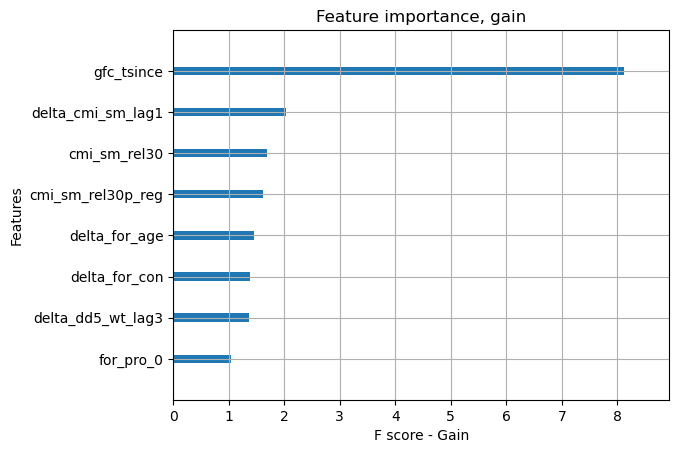

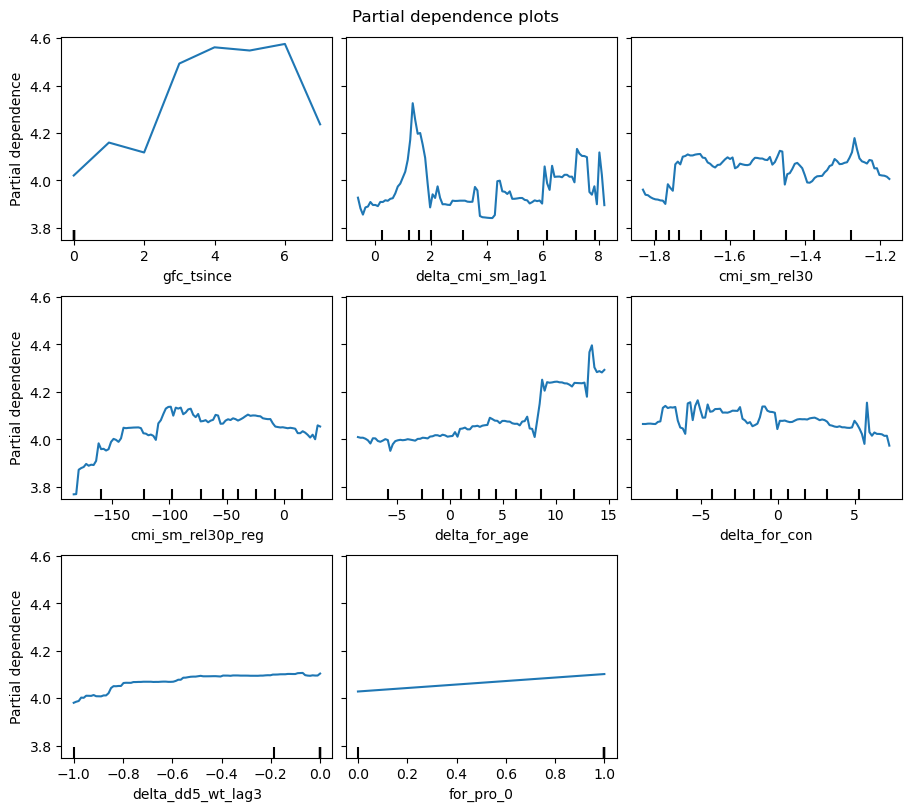

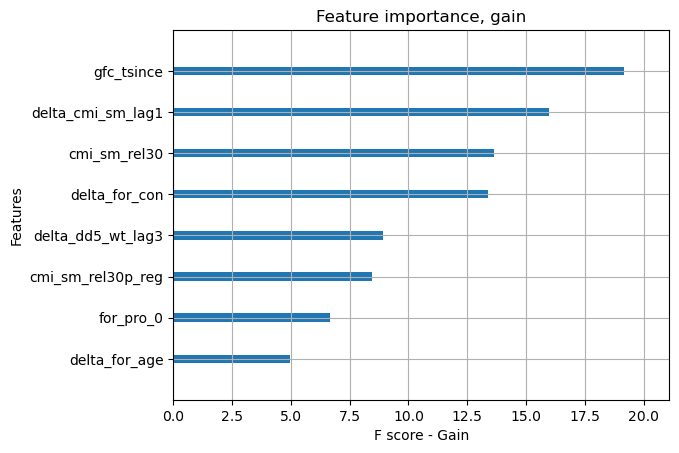

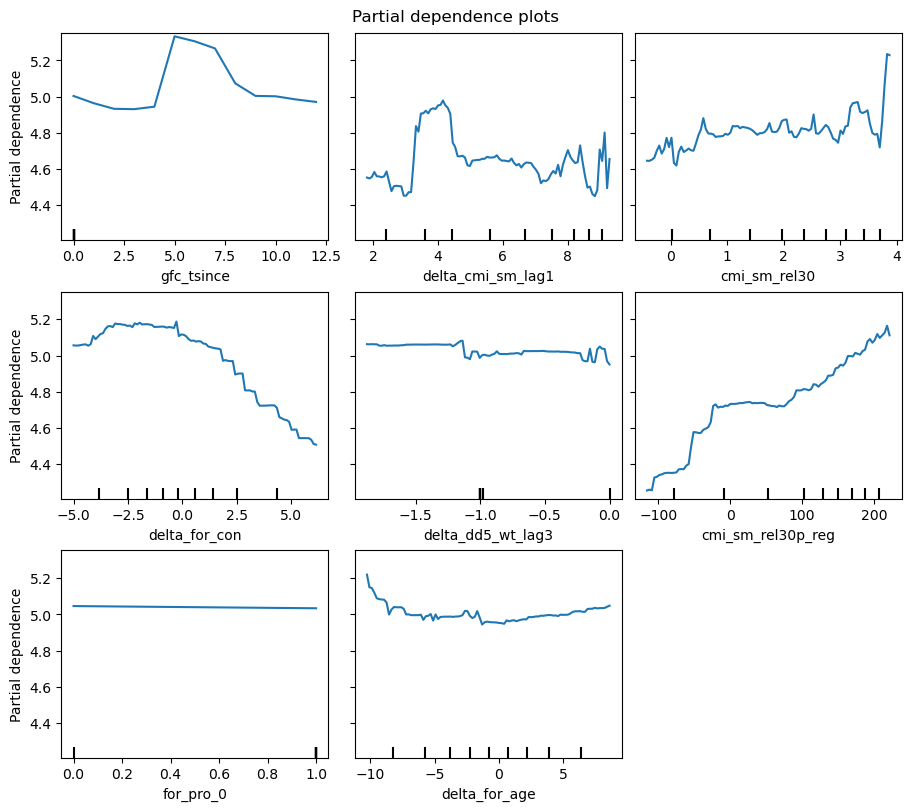

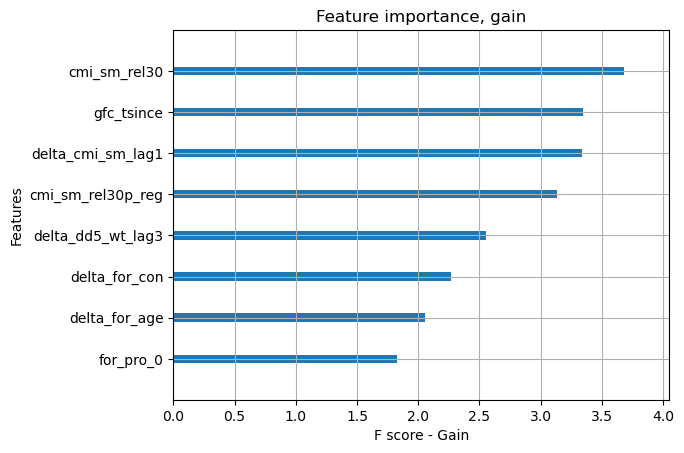

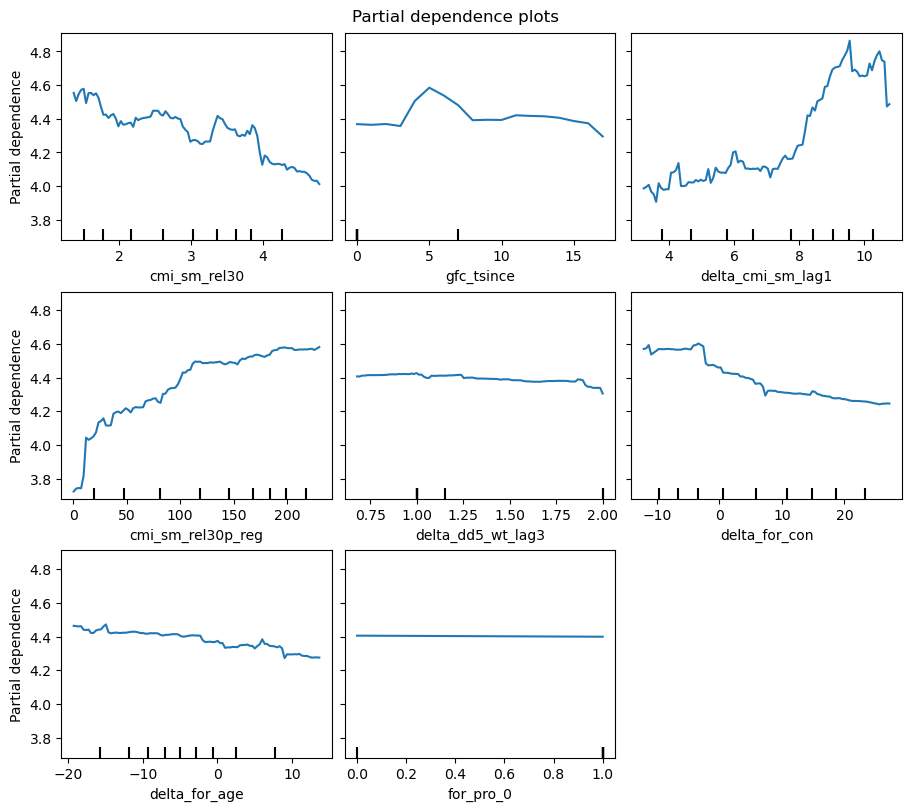

KeyError: "['gfc_tsince'] not in index"

In [148]:
# loop version
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']


for z in range(len(dfall)):
    list_of_vars = [[cols4]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall[z][x]
            #print(X1.describe())
            y1 = dfall[z].iloc[:,6].abs()
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.05, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            #pyplot.savefig(r'.\figs\version1\pos_gain_m{y}_v10.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
            #pyplot.savefig(r'.\figs\version1\pos_gain_p{y}_v10.png'.format(y=z+1),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            #pyplot.savefig(r'.\figs\version1\pos_partial_dep_p{y}_v10.png'.format(y=z+1),  dpi=300, bbox_inches='tight')

            pyplot.show()


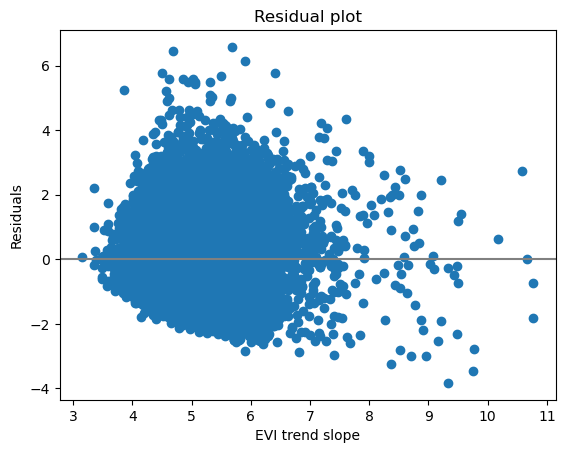

In [82]:
# Model prediction residuals

residuals = y1_test-y_pred

mean = residuals.mean()
std = residuals.std()

std_residuals = (residuals - mean)/std


pyplot.scatter(y_pred, std_residuals)

pyplot.ylabel('Residuals')
pyplot.xlabel("EVI trend slope")
pyplot.title('Residual plot')
pyplot.axhline(0, color="gray")

pyplot.show()

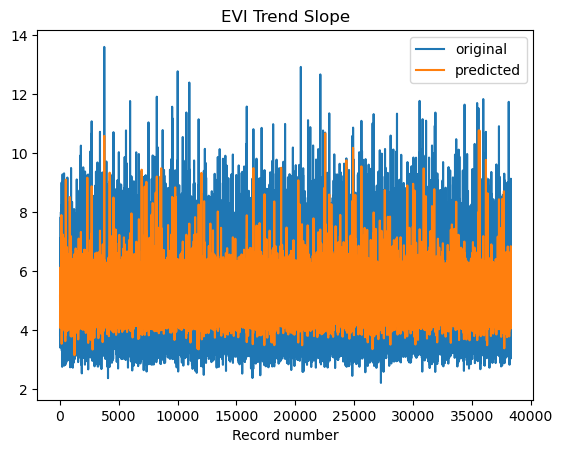

In [83]:
#import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
pyplot.plot(x_ax, y1_test, label="original")
pyplot.plot(x_ax, y_pred, label="predicted")

pyplot.xlabel("Record number") # Order of observations/records in vector

pyplot.title("EVI Trend Slope")

pyplot.legend()

#pyplot.savefig(r'.\figs\version1\pos_predicted_m{y}_v10.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')

pyplot.show()

In [84]:
# Plot tree. Use rankdir='LR' to make the plot show sideways
# import graphviz

#fig, ax = pyplot.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))

# format = 'png' #You should try the 'svg'

# image = xgb.to_graphviz(model_bp2, num_trees = model_bp2.best_iteration) # best_iteration only works with early_stop_rounds

#Set a different dpi (works only if format == 'png')
# image.graph_attr = {'dpi':'300'}

#image.render(r'.\figs\pos_decision_tree6.png', format = format)
# image.render(r'.\figs\version5\neg_decision_tree_m{y}_v1.png'.format(y=len(x)), format = format)

#-#image

In [85]:
# creat new df
#dfall2 = [df0]
# check once more
# df2.shape
#dfall2[0].shape
#dfall2[0].shape
#409+10609
#dfall2s1 = dfall2[0]
#dfall2s1[0].shape
#dfall3 = [df3]
#dfall3[0].shape

#### Models with undisturbed pixels

In [86]:
# Dataframes with matched disturbance pixels did not perform well.
dfall2 = [df16, df26, df36, df46]

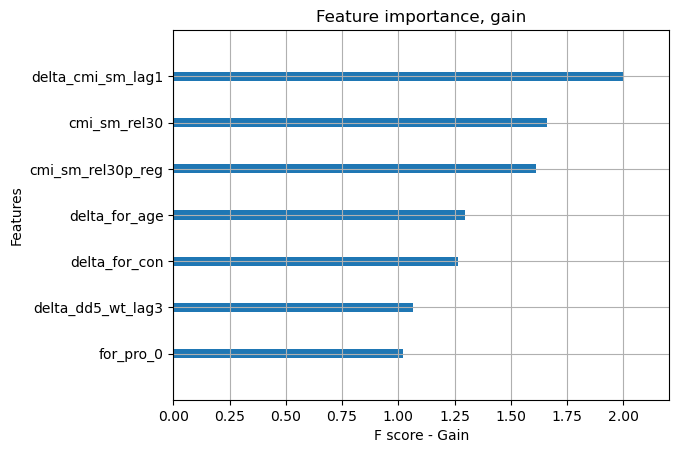

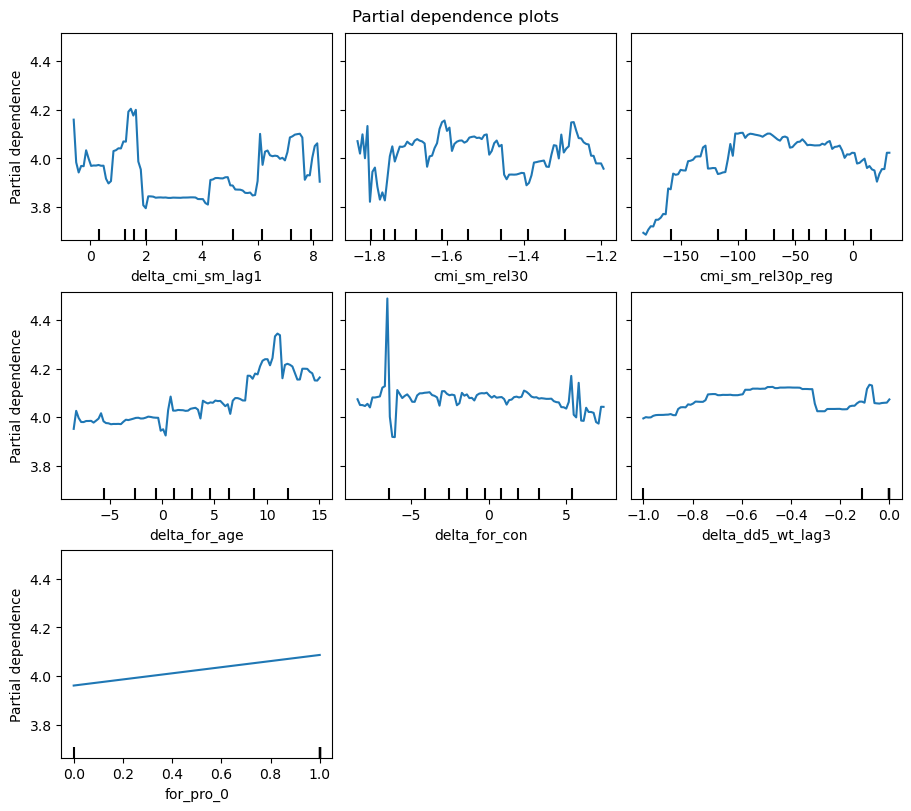

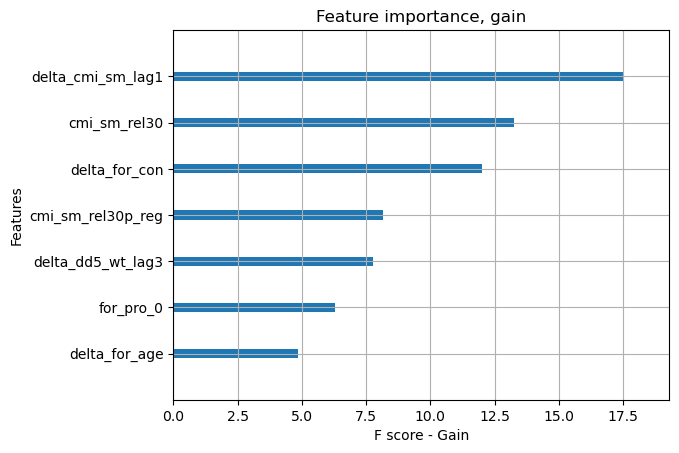

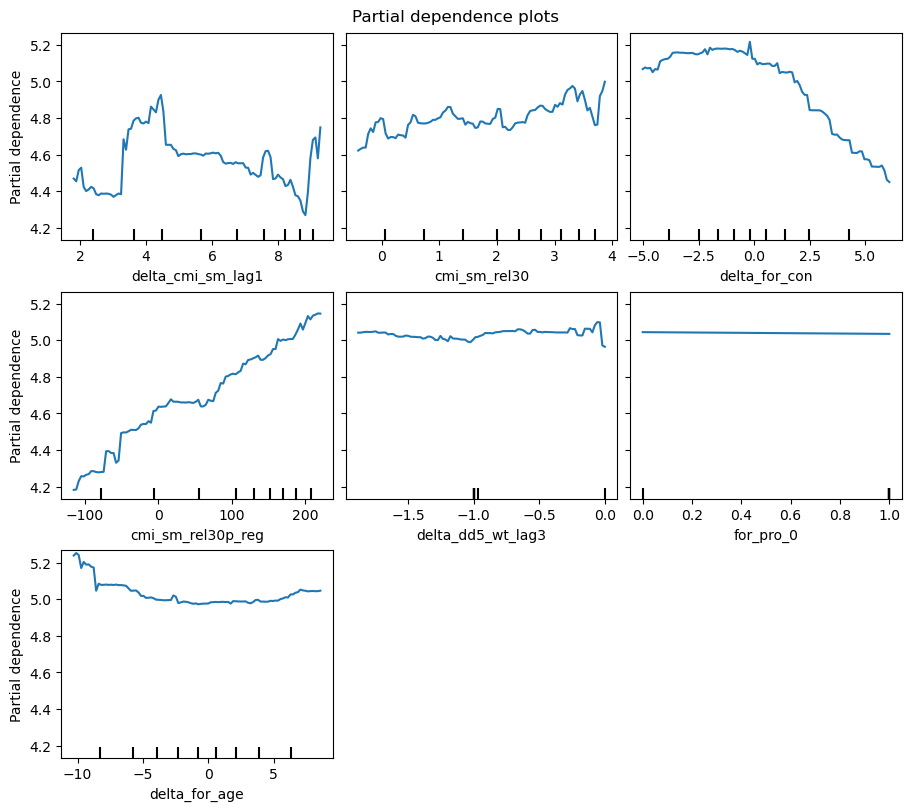

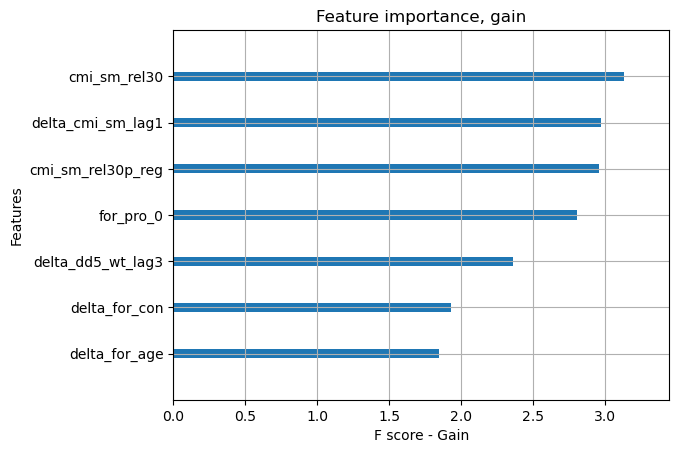

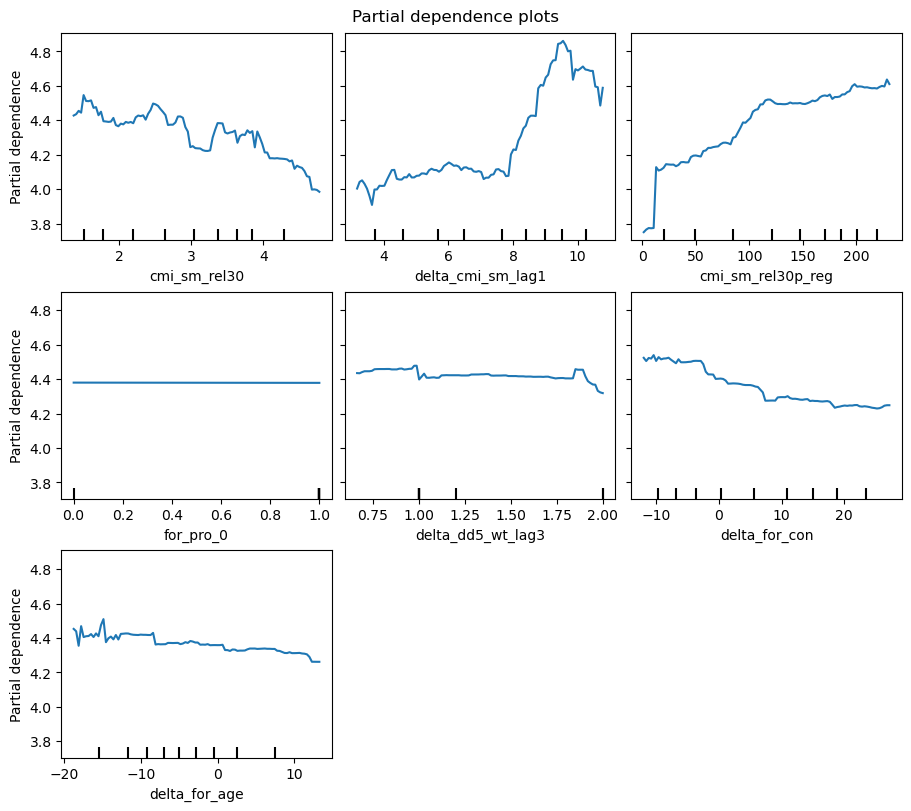

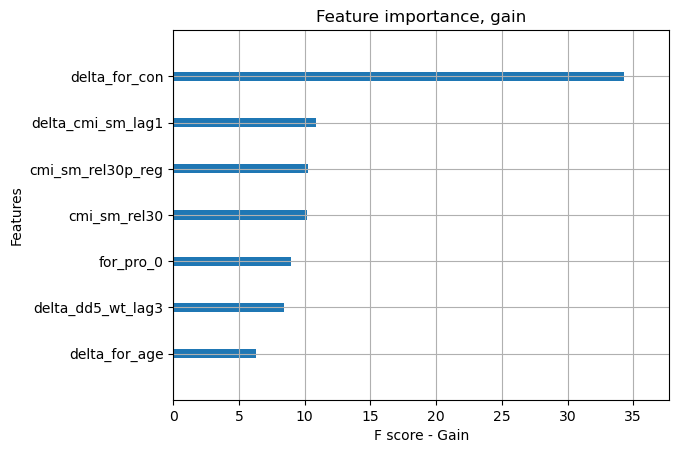

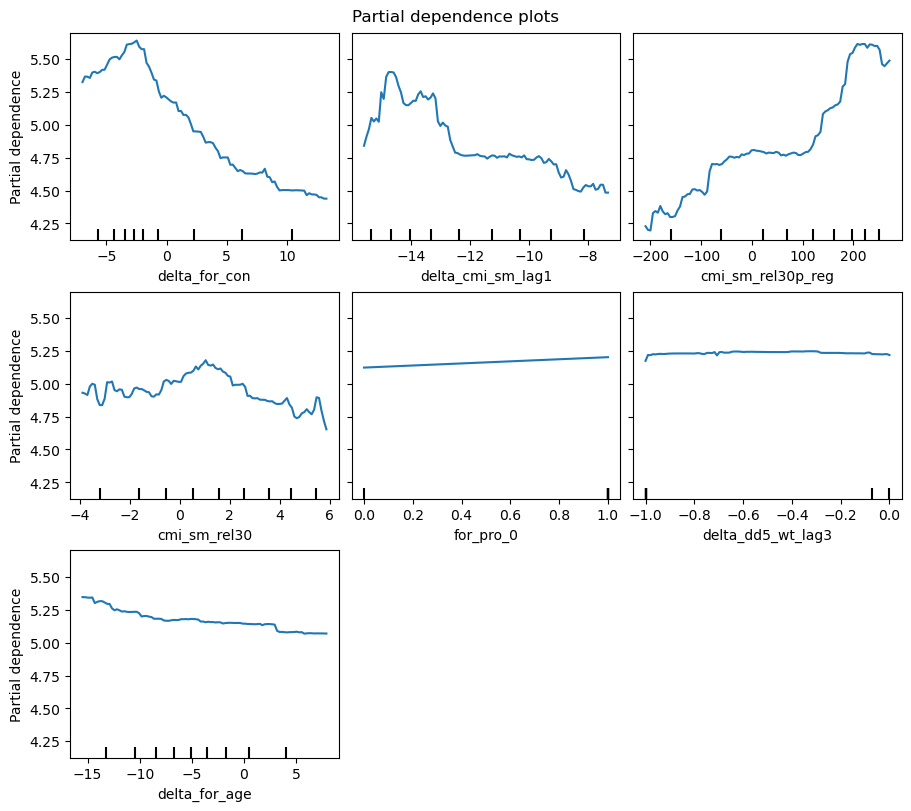

In [87]:
# Relative metric for split data, best where dist_0=1 (yes disturbance)
# Undisturbed dfs are the better ones
# loop version
#cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

#cols2 = ['delta_dd5_wt_lag3', 'delta_cmi_sm_lag2', 'delta_cmi_sm_lag1', 'delta_for_age', 'delta_for_con','for_pro_0']


for z in range(len(dfall2)):
    list_of_vars = [[cols2]]
    for index, list in enumerate(list_of_vars):
        for x in list:
            #print(x)
            X1 = dfall2[z][x]
            #print(X1.describe())
            y1 = dfall2[z].iloc[:,6]
            seed = 7 # random seed to help with replication
            testsize1 = 0.33 # percent of records to test after training
            x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
            model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=50,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.05, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=8, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=1000, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
               # EVALUATION (with test)
            eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
                #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
            model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
                # make predictions for test data
            y_pred = model_bp2.predict(x1_test)
            predictions = [round(value) for value in y_pred]
                # retrieve performance metrics
            results = model_bp2.evals_result()
            mse = mean_squared_error(y1_test, y_pred)
                #r2 = explained_variance_score(y1_test, ypred)
            r2 = r2_score(y1_test, y_pred)
                # adjusted R-squared
            adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))           
            
            # Feature importance plot
            xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                        xlabel='F score - Gain', ylabel='Features', 
                        importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )

            pyplot.savefig(r'.\figs\version1\pos_gain_p{y}_v10_undist.png'.format(y=z+1),  dpi=300, bbox_inches='tight')
            #pyplot.show()
            
            # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
            features_names1 = pd.DataFrame()
            features_names1['columns'] = X1.columns
            features_names1['importances'] = model_bp2.feature_importances_
            features_names1.sort_values(by='importances',ascending=False,inplace=True)
            features_names2 = features_names1['columns'].tolist()[0:10]

            # Partial dependence plots
            _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

            display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

            _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

            pyplot.savefig(r'.\figs\version1\pos_partial_dep_p{y}_v10_undist.png'.format(y=z+1),  dpi=300, bbox_inches='tight')

            pyplot.show()


In [88]:
#print(dfall3[0]['p1_trend_slope_rel'].describe()) # 11018

In [89]:
#dfall3 = [df6]
#dfall3[0].shape